In [1]:
# Script for training a denoiser
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/11.1.0'

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Import posterior samples with the inserted cluster of mass $6\times10^{14}~M_\odot$

In [3]:
from astropy.io import fits
filename = 'results/cluster/3e14/samples_0.148_3e14_'

samples148 = fits.getdata(filename+'0.fits').astype('float32')
for i in range(1,4):
    s = fits.getdata(filename+str(i)+'.fits')
    samples148 = np.concatenate([samples148, s], axis=0)

print(samples148.shape)

(200, 360, 360)


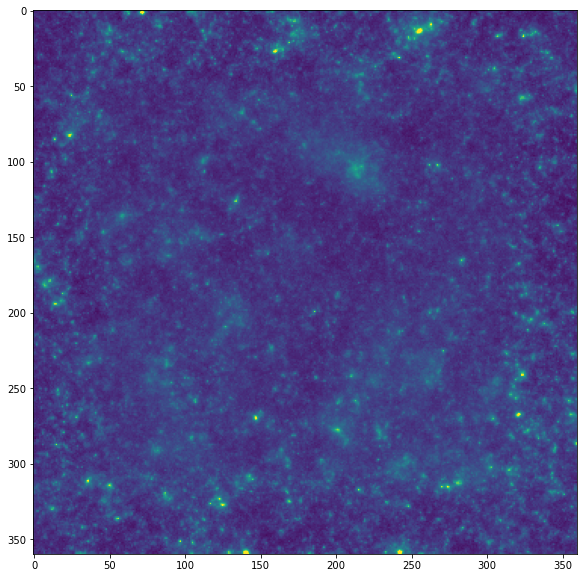

In [4]:
figure(figsize=(10,10))
imshow(samples148[2,...].reshape(360,360), vmin=-0.05, vmax=.3)

Window of size 32x32 centered in the cluster on posterior sample

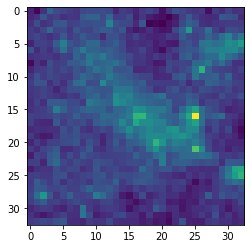

In [5]:
img = samples148[...].reshape(-1,360,360)

x=65
y=130

w = 16
ind = 4
imshow(img[ind,:][x-w:x+w+1, y-w:y+w+1])

Mean of the posterior samples

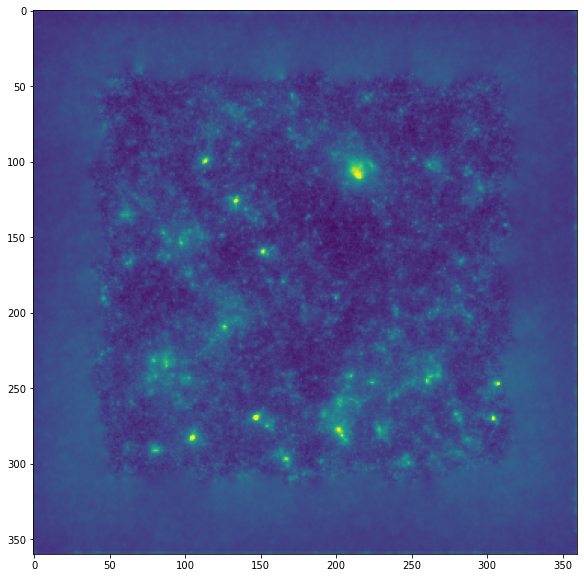

In [6]:
figure(figsize=[10,10])
imshow(img.mean(axis=0),vmax=0.15)

Window of size 32x32 centered in the cluster on posterior mean

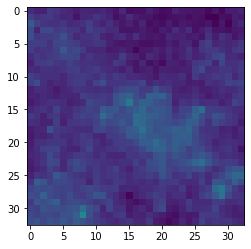

In [7]:
imshow(img[:,x-w:x+w+1, y-w:y+w+1].mean(axis=0),vmax=0.15)

Import samples without the insterted cluster

In [8]:
filename = 'results/validation/samples_'
samplesback = fits.getdata(filename+'11.fits').astype('float32')

for i in range(2,5):
    s = fits.getdata(filename+str(i)+str(i)+'.fits')
    samplesback = np.concatenate([samplesback, s], axis=0)

print(samplesback.shape)

(200, 360, 360)


In [9]:
img_background = samplesback[...].reshape(-1,360,360)

Text(0.5, 1.0, 'mean cluster')

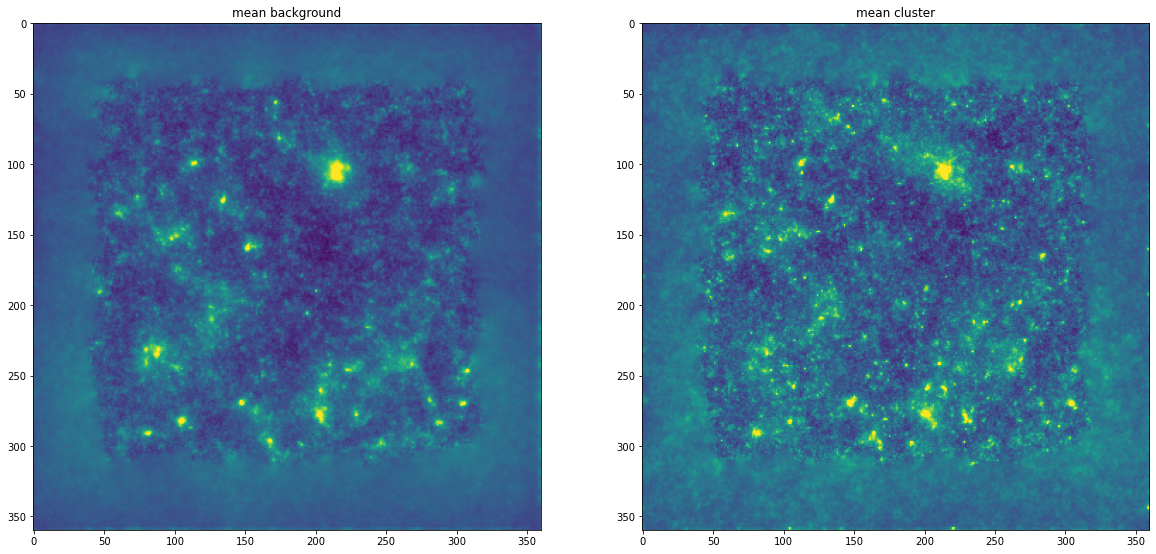

In [10]:
figure(figsize=[20,10])
subplot(121)
imshow(img_background.mean(axis=0),vmax=0.1)
title('mean background')
subplot(122)
imshow(img[:27].mean(axis=0),vmax=0.1)
title('mean cluster')

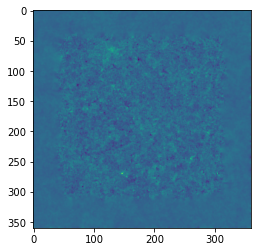

In [11]:
imshow(img[:].mean(axis=0) - img_background.mean(axis=0))

Text(0.5, 1.0, 'mean background')

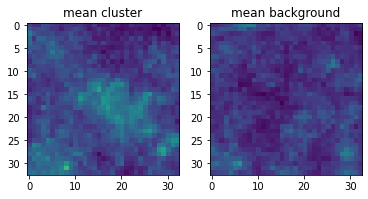

In [12]:
subplot(121)
imshow(img[:,x-w:x+w+1, y-w:y+w+1].mean(axis=0),vmax=0.1)
title('mean cluster')
subplot(122)
imshow(img_background[:,x-w:x+w+1, y-w:y+w+1].mean(axis=0),vmax=0.1)
title('mean background')

## Filter images for detection

In [13]:
import lenspack

In [14]:
radius = linspace(0,16,16)

In [15]:
lenspack.image.filters.aperture_mass?

Method to create a NFW profile

In [16]:
from lenspack.halo.profiles import nfw_profile
from astropy import units as u
from lenspack.image.inversion import ks93, ks93inv

def gen_nfw_shear(x_cen, y_cen, resolution, nx, ny, z, m, zs=None, redshift_distribution=None, como=None):
    """
    returns: a map g1,g2 of size [nx,ny]
    """

    halo = nfw_profile(z=z, c200=1, m200=m, r200=None, cosmology='default')

    resolution = resolution*u.arcmin #arcmin/pixel
    cosmo = halo.cosmo
    d_A = cosmo.angular_diameter_distance(z=z_halo)
    distance_Mpc = (resolution * d_A).to(u.Mpc, u.dimensionless_angles()) # Mpc/pixel

    dist_from_halo = np.zeros((nx, ny)) 
    phi_halo = np.zeros((nx, ny))

    for i in range(ny):
        for j in range(nx):
            dist_from_halo[i,j] = np.sqrt((i-x)**2 + (j-y)**2)
            #phi_halo[i,j] =  np.arccos((j-y) / dist_from_halo[i,j])

    for i in range(ny):
        for j in range(nx):
            if i-x > 0:
                phi_halo[i,j] =  np.arccos((j-y) / dist_from_halo[i,j])
            else:
                phi_halo[i,j] = 2*np.pi - np.arccos((j-y) / dist_from_halo[i,j])

    dist_from_halo = dist_from_halo * distance_Mpc
    phi_halo[x, y] = 0.
    
    gamma_t = halo.gamma_t(r=dist_from_halo, zs=zs)

    gamma_1 = - gamma_t * np.cos(2*phi_halo)
    gamma_2 = - gamma_t * np.sin(2*phi_halo)
    
    return gamma_1, gamma_2

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/tensorflow-gpu-2.5.0/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


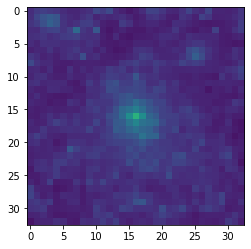

In [17]:
from lenspack.image.inversion import ks93, ks93inv
convergence = fits.getdata('../../data/ktng/ktng_cosmos_kappa360.fits').astype('float32')
meas_shear = np.stack(ks93inv(convergence, np.zeros_like(convergence)), axis=-1)

resolution = 0.29 #arcmin/pixel
z_halo = 0.5
mass_halo = 3e14
zs = 1

nx = 360# map width pixel
ny = 360 # map height pixel
x = 65 # cluster x coord pixel
y = 130 # cluster y coord pixel

g1, g2 = gen_nfw_shear(x_cen=x, y_cen=y, resolution=resolution, nx=nx, ny=ny, z=z_halo, m=mass_halo, zs=zs)
ke_cluster, kb_cluster = ks93(meas_shear[...,0] + g1, meas_shear[...,1] + g2)

w = 16

vmin = -0.05
vmax = 0.3
imshow(ke_cluster[x-w:x+w+1, y-w:y+w+1], vmin=vmin, vmax=vmax)

In [18]:
def detection_filter(img, ke, nfw, noise, filter_name='jbj04'):
    
    radius = linspace(0,16,16)
    res = [lenspack.image.filters.aperture_mass(img[:,x-w:x+w+1, y-w:y+w+1].mean(axis=0), i, filter=filter_name)
           for i in radius]
    res = np.stack(res,axis=0)
    
    resb = [lenspack.image.filters.aperture_mass(img_background[:,x-w:x+w+1, y-w:y+w+1].mean(axis=0), i, 
                                                 filter=filter_name) 
            for i in radius]
    
    resb = np.stack(resb,axis=0)

    std = resb.reshape([16,-1]).std(axis=1)[-1]
    rad = radius[-1]

    filtered_img = [lenspack.image.filters.aperture_mass(img[i,x-w:x+w+1, y-w:y+w+1],
                                                         rad,
                                                         filter=filter_name)
                    for i in range(len(img))]

    filtered_img = np.stack(filtered_img,axis=0)
    
    det = filtered_img[:, 16,16]/std > 5.
    non_det = filtered_img[:, 16,16]/std < 5.
    
    # compute SNR
    filtered_cluster = lenspack.image.filters.aperture_mass(ke[x-w:x+w+1, y-w:y+w+1], rad, filter=filter_name)
    #snr = filtered_cluster[16,16]/std
    signal = lenspack.image.filters.aperture_mass(nfw[x-w:x+w+1, y-w:y+w+1], rad, filter=filter_name)
    snr = [np.max(signal) / noise, np.std(signal) / noise]
    
    return snr, where(det)[0].shape[0]/len(det), filtered_img

In [19]:
# filter : {'s98', 'vw98', 'jbj04', 'starlet'}
filter='starlet'

In [20]:
res = [lenspack.image.filters.aperture_mass(img[:,x-w:x+w+1, y-w:y+w+1].mean(axis=0), i, filter=filter ) for i in radius]
res = np.stack(res,axis=0)

In [21]:
resb = [lenspack.image.filters.aperture_mass(img_background[:,x-w:x+w+1, y-w:y+w+1].mean(axis=0), i, filter=filter) for i in radius]
resb = np.stack(resb,axis=0)

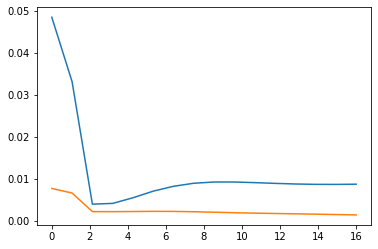

In [22]:
plot(radius, res[:,16,16])
plot(radius, resb.reshape([16,-1]).std(axis=1))

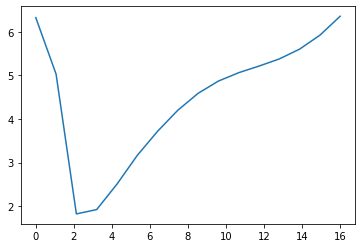

In [23]:
plot(radius, res[:,16,16]/resb.reshape([16,-1]).std(axis=1))

In [24]:
std = resb.reshape([16,-1]).std(axis=1)[-1]
rad = radius[-1]
rad, std

(16.0, 0.0013640251241389275)

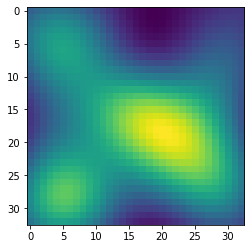

In [25]:
imshow(lenspack.image.filters.aperture_mass(img[:,x-w:x+w+1, y-w:y+w+1].mean(axis=0), rad, filter=filter))

0.12693245910650827


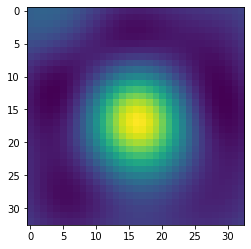

In [26]:
filtered_cluster = lenspack.image.filters.aperture_mass(ke_cluster[x-w:x+w+1, y-w:y+w+1], rad, filter=filter)
print(filtered_cluster[16,16]/0.148)
imshow(filtered_cluster)

In [27]:
filtered_img = [lenspack.image.filters.aperture_mass(img[i,x-w:x+w+1, y-w:y+w+1], rad, filter=filter) for i in range(len(img))]

In [28]:
filtered_back = [lenspack.image.filters.aperture_mass(img_background[i,x-w:x+w+1, y-w:y+w+1], rad, filter=filter) for i in range(len(img_background))]

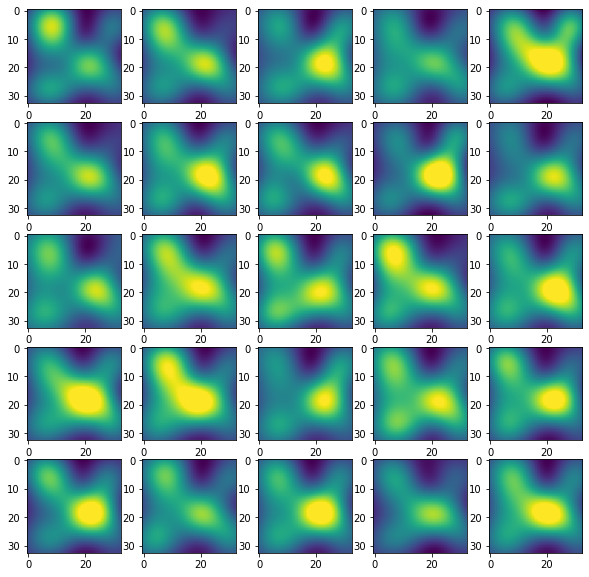

In [29]:
figure(figsize=[10,10])
try:
  for i in range(25):
    subplot(5,5,i+1)
    imshow(filtered_img[i]/std,vmax=10)
except ValueError:
  pass

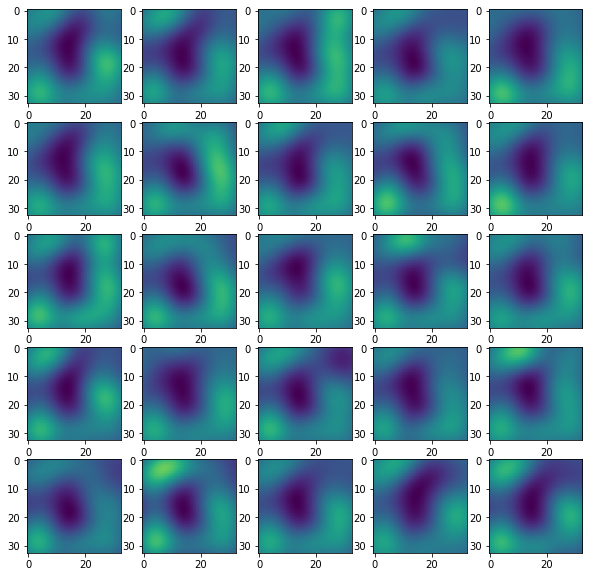

In [30]:
figure(figsize=[10,10])
try:
  for i in range(25):
    subplot(5,5,i+1)
    imshow(filtered_back[i]/std,vmax=10)
except IndexError:
  pass

In [31]:
filtered_img = np.stack(filtered_img,axis=0)

In [32]:
filtered_back = np.stack(filtered_back,axis=0)

In [33]:
filtered_img.shape, filtered_back.shape

((200, 33, 33), (200, 33, 33))

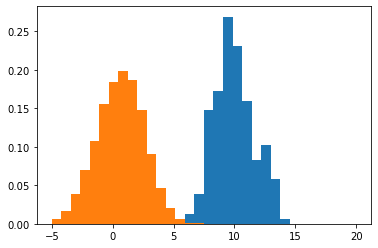

In [34]:
hist(filtered_img.reshape([filtered_img.shape[0], -1]).max(axis=1)/std, 32, range=[-5,20],density=True);
hist(filtered_back.flatten()/std, 32, range=[-5,20],density=True);

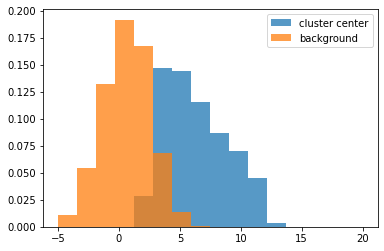

In [35]:
hist(filtered_img[:, 16,16]/std, 16, range=[-5,20],density=True,alpha=0.75,label='cluster center');
hist(filtered_back.flatten()/std, 16, range=[-5,20],density=True,alpha=0.75,label='background');
legend()

In [36]:
# ok, so let's pick a detection threshold around 5 sigma

In [37]:
det = filtered_img[:, 16,16]/std > 5.
non_det = filtered_img[:, 16,16]/std < 5.

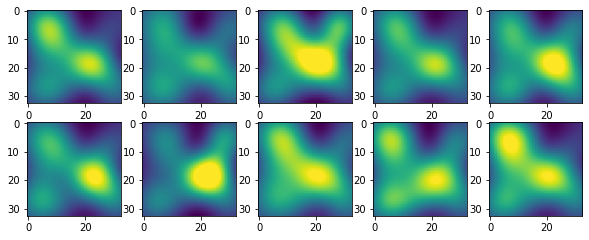

In [38]:
figure(figsize=[10,10])
try:
  for i in range(10):
    subplot(5,5,i+1)
    imshow(filtered_img[det][i]/std,vmax=10)
    savefig('detection_yes_3e14.png')
except IndexError:
  pass

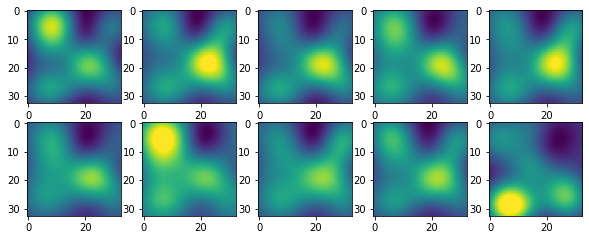

In [39]:
figure(figsize=[10,10])
try:
  for i in range(10):
    subplot(5,5,i+1)
    imshow(filtered_img[non_det][i]/std,vmax=10)
    savefig('detection_no_3e14.png')
except IndexError:
  pass

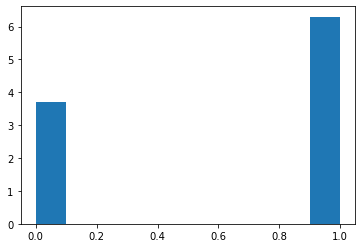

In [40]:
hist(det*1., density=True);

In [41]:
print('Amount of detection,:', where(det)[0].shape[0]/len(det))

Amount of detection,: 0.63


0.18858660080144268
0.14611032293476103


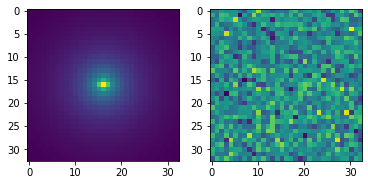

In [42]:
ke_cluster_alone, kb_cluster_alone = ks93(g1, g2)
w = 16
subplot(121)
imshow(ke_cluster_alone[x-w:x+w+1, y-w:y+w+1])
signal = np.max(ke_cluster_alone[x-w:x+w+1, y-w:y+w+1])
print(signal)

subplot(122)
ke_back, kb_back = ks93(meas_shear[...,0]+.148*random.randn(360,360), meas_shear[...,1]+.148*random.randn(360,360))
imshow(ke_back[x-w:x+w+1, y-w:y+w+1])
noise_back = np.std(ke_back[x-w:x+w+1, y-w:y+w+1])
print(noise_back)

Signal: 0.02292727632309225
Noise: 0.0071763024285950465
SNR: 3.1948592678779955


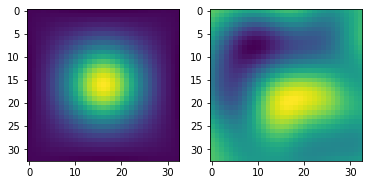

In [43]:
#w = 20

filt_cluster = lenspack.image.filters.aperture_mass(ke_cluster_alone[x-w:x+w+1, y-w:y+w+1], rad, filter=filter)
filt_back = lenspack.image.filters.aperture_mass(ke_back[x-w:x+w+1, y-w:y+w+1], rad, filter=filter)

subplot(121)
print('Signal:', np.max(filt_cluster))
imshow(filt_cluster)

subplot(122)
print('Noise:', np.std(filt_back))
noise = np.std(filt_back)
imshow(filt_back)

print('SNR:', np.max(filt_cluster)/np.std(filt_back))

Import results samples

In [44]:
filename = 'results/cluster/9e13/samples_0.148_9e13_'
samples913 = fits.getdata(filename+'0.fits').astype('float32')
g1, g2 = gen_nfw_shear(x_cen=x, y_cen=y, resolution=resolution,
                       nx=nx, ny=ny, z=z_halo, m=9e13, zs=zs)
for i in range(1,4):
    s = fits.getdata(filename+str(i)+'.fits')
    samples913 = np.concatenate([samples913, s], axis=0)
ke913, _ = ks93(meas_shear[...,0] + g1, meas_shear[...,1] + g2)
nfw913,_ = ks93(g1, g2)
        
filename = 'results/cluster/3e14/samples_0.148_3e14_'
samples314 = fits.getdata(filename+'0.fits').astype('float32')
for i in range(1,4):
    s = fits.getdata(filename+str(i)+'.fits')
    samples314 = np.concatenate([samples314, s], axis=0)
g1, g2 = gen_nfw_shear(x_cen=x, y_cen=y, resolution=resolution, nx=nx, ny=ny, z=z_halo, m=3e14, zs=zs)
ke314, _ = ks93(meas_shear[...,0] + g1, meas_shear[...,1] + g2)
nfw314,_ = ks93(g1, g2)

filename = 'results/cluster/6e14/samples_0.148_6e14_'
samples614 = fits.getdata(filename+'0.fits').astype('float32')
for i in range(1,4):
    s = fits.getdata(filename+str(i)+'.fits')
    samples614 = np.concatenate([samples614, s], axis=0)
g1, g2 = gen_nfw_shear(x_cen=x, y_cen=y, resolution=resolution, nx=nx, ny=ny, z=z_halo, m=6e14, zs=zs)
ke614, _ = ks93(meas_shear[...,0] + g1, meas_shear[...,1] + g2)
nfw614,_ = ks93(g1, g2)

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/tensorflow-gpu-2.5.0/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


Choose a filter among: {'s98', 'vw98', 'jbj04', 'starlet'}

In [45]:
filter_name = 'starlet'

In [46]:
det913_starlet = detection_filter(samples913.reshape(-1,360,360), ke913, nfw913, noise, filter_name='starlet')

In [47]:
det314_starlet = detection_filter(samples314.reshape(-1,360,360), ke314, nfw314, noise, filter_name='starlet')

In [48]:
det614_starlet = detection_filter(samples614.reshape(-1,360,360), ke614, nfw614, noise, filter_name='starlet')

In [49]:
k = 0 # max
#k = 1 # sum

snr_starlet = [det913_starlet[0][k], det314_starlet[0][k], det614_starlet[0][k]]
ratio_starlet = [det913_starlet[1], det314_starlet[1], det614_starlet[1]]

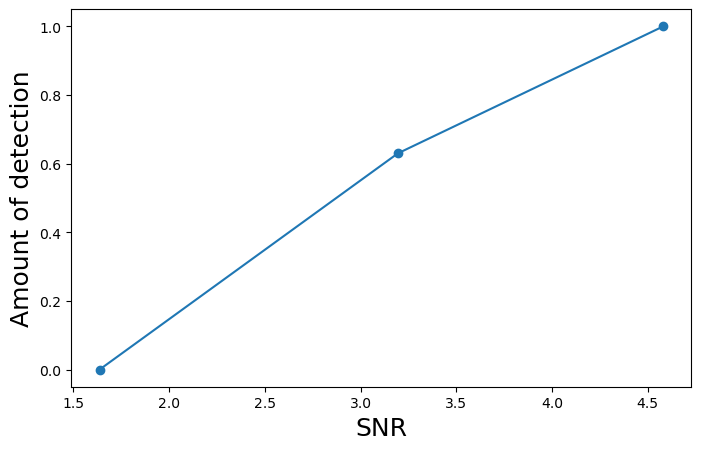

In [50]:
figure(figsize=(8,5), dpi=100)
plot(snr_starlet, ratio_starlet, label='starlet')
#plot(snr_jbj04, ratio_jbj04, label='jbj04')
scatter(snr_starlet, ratio_starlet)
xlabel('SNR', fontsize=18)
ylabel('Amount of detection', fontsize=18)
savefig('plots/SNR.pdf')
#legend()

In [51]:
rg = dict(range=[-10,35])

In [52]:
n_bins = 32
kwargs = dict(histtype='stepfilled', linewidth=2., fc="None", density=True, bins=n_bins, **rg)

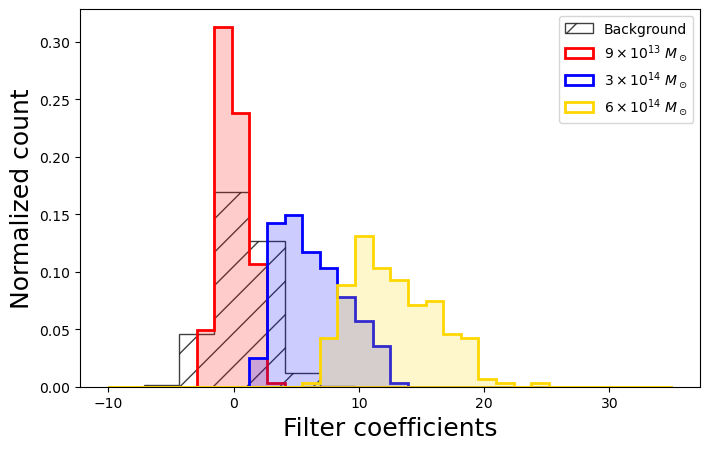

In [53]:
figure(figsize(8,5), dpi=100)

plt.rcParams.update({'hatch.color': 'black'})

hist(filtered_back.flatten()/std, hatch='/', label='Background', alpha=.75, fc="None", ec='black', histtype='stepfilled', **rg, density=True, bins=16);
hist(det913_starlet[2][:, 16,16]/std,label=r'$9\times10^{13}~M_\odot$', ec='red', alpha=1, **kwargs);
hist(det913_starlet[2][:, 16,16]/std, color='red', alpha=.2, density=True, **rg, bins=n_bins);
hist(det314_starlet[2][:, 16,16]/std,label=r'$3\times10^{14}~M_\odot$', ec='blue',  alpha=1, **kwargs);
hist(det314_starlet[2][:, 16,16]/std, color='blue', alpha=.2, density=True, **rg, bins=n_bins);
hist(det614_starlet[2][:, 16,16]/std,label=r'$6\times10^{14}~M_\odot$', ec='gold', alpha=1, **kwargs);
hist(det614_starlet[2][:, 16,16]/std, color='gold', alpha=.2, density=True, **rg, bins=n_bins);
xlabel('Filter coefficients', fontsize=18)
ylabel('Normalized count', fontsize=18)
legend()

savefig('plots/hist_detection.pdf')